# Decision Trees Partitions

|                |   |
:----------------|---|
| **Name**     | Eddie Aguilar  |
| **Date**      | 04/24/2025  |
| **ID** | 739352  | 

## 1. Theory

In regression trees, the criterion used to make partitions is to minimize the combined variance, since the outputs are continuous values. However, in classification trees, where the outputs are categories, we need other criteria to determine the best partitions. These criteria seek to maximize the purity of the resulting nodes, meaning that the nodes should contain examples of the same class.

### 1.1 Gini Index

The Gini index is a measure of impurity that quantifies the probability of incorrectly classifying an observation if it were randomly labeled according to the class distribution in the node.

Mathematically, the Gini index is defined as:

$$Gini = 1 - \sum_{i=1}^{m} p_i^2$$

Where:
- $m$ is the number of classes
- $p_i$ is the proportion of observations of class $i$ in the node

Key characteristics:
- A Gini value = 0 indicates perfect purity (all observations belong to the same class)
- Higher values indicate greater impurity
- The maximum value is $(1 - 1/m)$ when observations are evenly distributed across all classes

When evaluating a potential partition, we calculate the weighted Gini index of the resulting nodes:

$$Gini_{split} = \frac{n_{left}}{n} Gini_{left} + \frac{n_{right}}{n} Gini_{right}$$

We choose the partition that minimizes this value.

### 1.2 Entropy

Entropy is a measure of disorder or uncertainty. In the context of decision trees, it quantifies the impurity in the dataset.

Mathematically, entropy is defined as:

$$Entropy = -\sum_{i=1}^{m} p_i \log_2(p_i)$$

Where:
- $m$ is the number of classes
- $p_i$ is the proportion of observations of class $i$ in the node

Key characteristics:
- An entropy = 0 indicates perfect purity (all observations belong to the same class)
- The maximum entropy is $\log_2(m)$ when observations are evenly distributed across all classes

When evaluating a partition, we calculate the information gain:

$$Information\_gain = Entropy_{parent} - \left( \frac{n_{left}}{n} Entropy_{left} + \frac{n_{right}}{n} Entropy_{right} \right)$$

We choose the partition that maximizes this information gain.

### 1.3 Log Loss (Cross-Entropy Loss)

Log Loss, also known as cross-entropy loss, is a performance measure for classification models whose output is a probability.

Mathematically, for binary problems, Log Loss is defined as:

$$LogLoss = -\frac{1}{n}\sum_{i=1}^{n} [y_i \log(p_i) + (1-y_i) \log(1-p_i)]$$

For multiclass problems:

$$LogLoss = -\frac{1}{n}\sum_{i=1}^{n}\sum_{j=1}^{m} y_{ij} \log(p_{ij})$$

Where:
- $n$ is the number of observations
- $m$ is the number of classes
- $y_{ij}$ is 1 if observation $i$ belongs to class $j$, and 0 otherwise
- $p_{ij}$ is the predicted probability that observation $i$ belongs to class $j$

Key characteristics:
- A lower Log Loss indicates better predictions
- Severely penalizes incorrect predictions with high confidence
- Used as a loss function in model optimization

### 1.4 Difference Between Entropy and Log Loss

Although both concepts use logarithmic functions and are mathematically related, there are important differences:

| Aspect | Entropy | Log Loss |
|--------|---------|----------|
| **Purpose** | Measures the impurity of a dataset based on the class distribution. Used to decide how to split the data during tree construction. | Evaluates how well the probabilities predicted by a model fit the actual classes. Used as a loss function or evaluation metric, not directly for making partitions. |
| **Application Context** | Calculated with the actual class proportions in a dataset. | Compares predicted probabilities with actual classes. |
| **Mathematical Interpretation** | Can be viewed as the amount of information (in bits) needed to encode the class distribution. | Can be interpreted as the Kullback-Leibler divergence between the true distribution and the predicted distribution. |


## 2. Practical implementation

Next, we'll use the "Heart Prediction Quantum Dataset" to demonstrate how partitions are made under different criteria (Gini, Entropy, Log Loss).

### 2.1 Preparation

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, classification_report

%matplotlib inline
#plt.style.use('ggplot')

#### Load data

In [27]:
df = pd.read_csv(r'C:\Users\AgJo413\Documents\GitHub\Lab_std\labstds\Data\Heart Prediction Quantum Dataset.csv')

df.head()

,Age,Gender,BloodPressure,Cholesterol,HeartRate,QuantumPatternFeature,HeartDisease
0,68,1,105,191,107,8.362241,1
1,58,0,97,249,89,9.249002,0
2,44,0,93,190,82,7.942542,1
3,72,1,93,183,101,6.495155,1
4,37,0,145,166,103,7.653900,1


#### Statistical summary

In [28]:
df.describe()

,Age,Gender,BloodPressure,Cholesterol,HeartRate,QuantumPatternFeature,HeartDisease
count,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000
mean,54.864000,0.468000,132.874000,221.50000,88.766000,8.317407,0.600000
std,14.315004,0.499475,26.418516,43.86363,17.417289,0.919629,0.490389
min,30.000000,0.000000,90.000000,150.00000,60.000000,6.164692,0.000000
25%,43.000000,0.000000,111.000000,183.75000,73.000000,7.675779,0.000000
50%,55.000000,0.000000,132.000000,221.00000,89.000000,8.323064,1.000000
75%,66.250000,1.000000,155.000000,258.00000,104.000000,8.935999,1.000000
max,79.000000,1.000000,179.000000,299.00000,119.000000,10.784886,1.000000


#### Target distribution

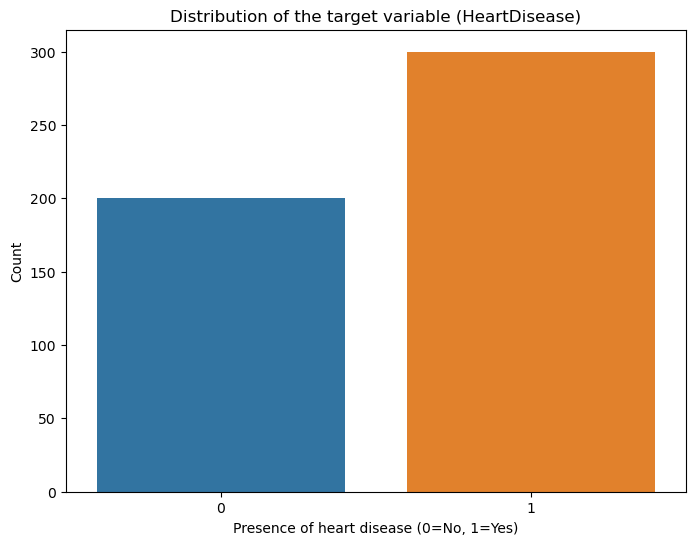

Class distribution:
HeartDisease
1    60.0
0    40.0
Name: proportion, dtype: float64


In [29]:
# Check the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='HeartDisease', data=df)
plt.title('Distribution of the target variable (HeartDisease)')
plt.xlabel('Presence of heart disease (0=No, 1=Yes)')
plt.ylabel('Count')
plt.show()

# Show percentages
print("Class distribution:")
print(df['HeartDisease'].value_counts(normalize=True).round(3) * 100)

#### Data Preparation

In [30]:
# Prepare data for modeling
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 2.2 Partitions with Gini Criterion

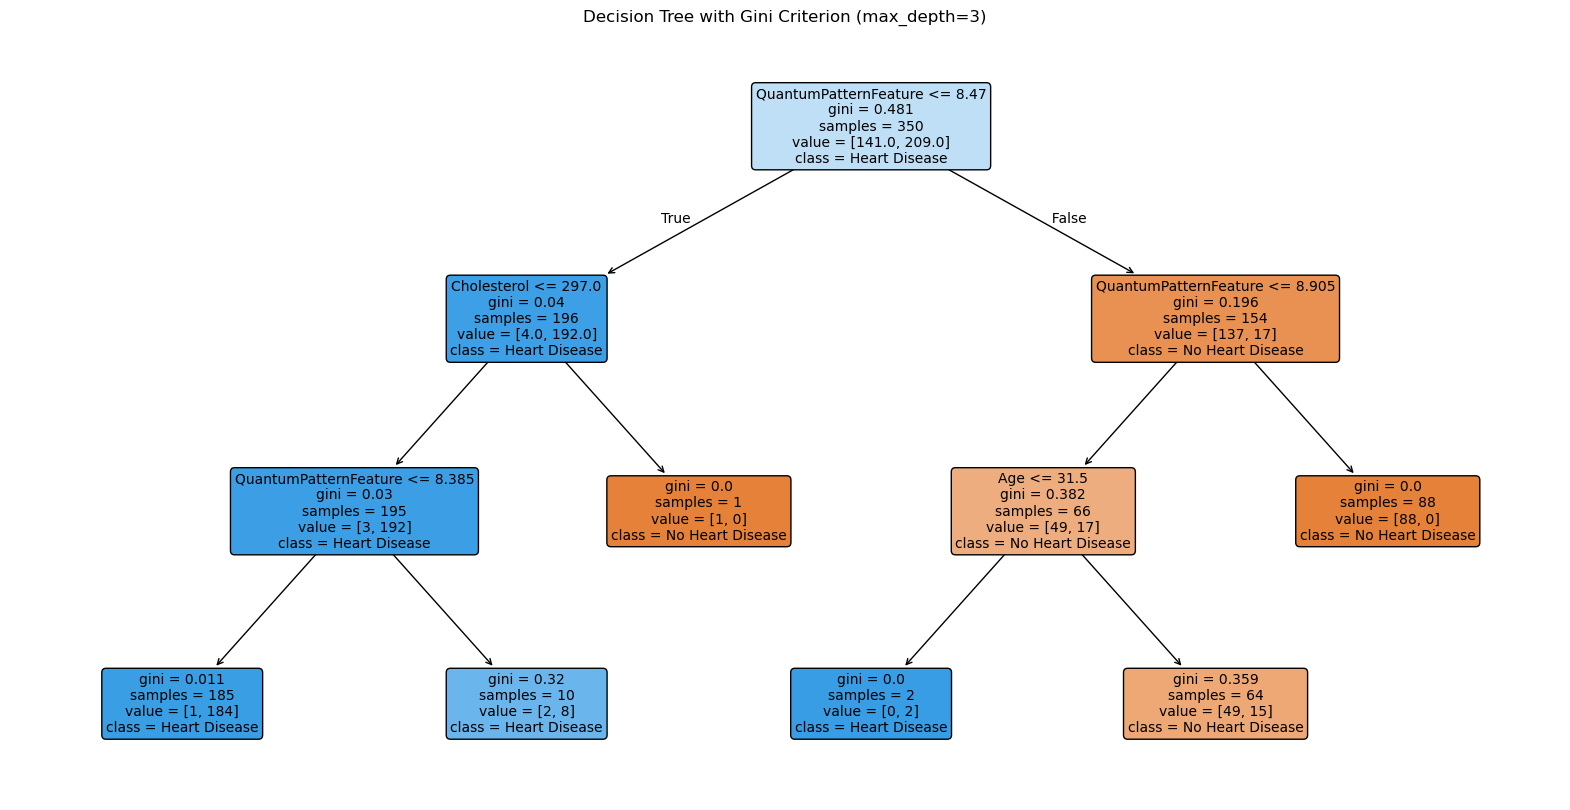

In [31]:
# Create a decision tree with Gini criterion (default)
tree_gini = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=42)
tree_gini.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(tree_gini, feature_names=X.columns, class_names=['No Heart Disease', 'Heart Disease'], 
          filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree with Gini Criterion (max_depth=3)')
plt.show()

In [32]:
# Evaluate the performance of the Gini model
y_pred_gini = tree_gini.predict(X_test)
accuracy_gini = accuracy_score(y_test, y_pred_gini)

print(f"Accuracy of the model with Gini criterion: {accuracy_gini:.4f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred_gini))

Accuracy of the model with Gini criterion: 0.9067

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89        59
           1       0.96      0.88      0.92        91

    accuracy                           0.91       150
   macro avg       0.90      0.91      0.90       150
weighted avg       0.91      0.91      0.91       150



### 2.3 Partitions with Entropy Criterion

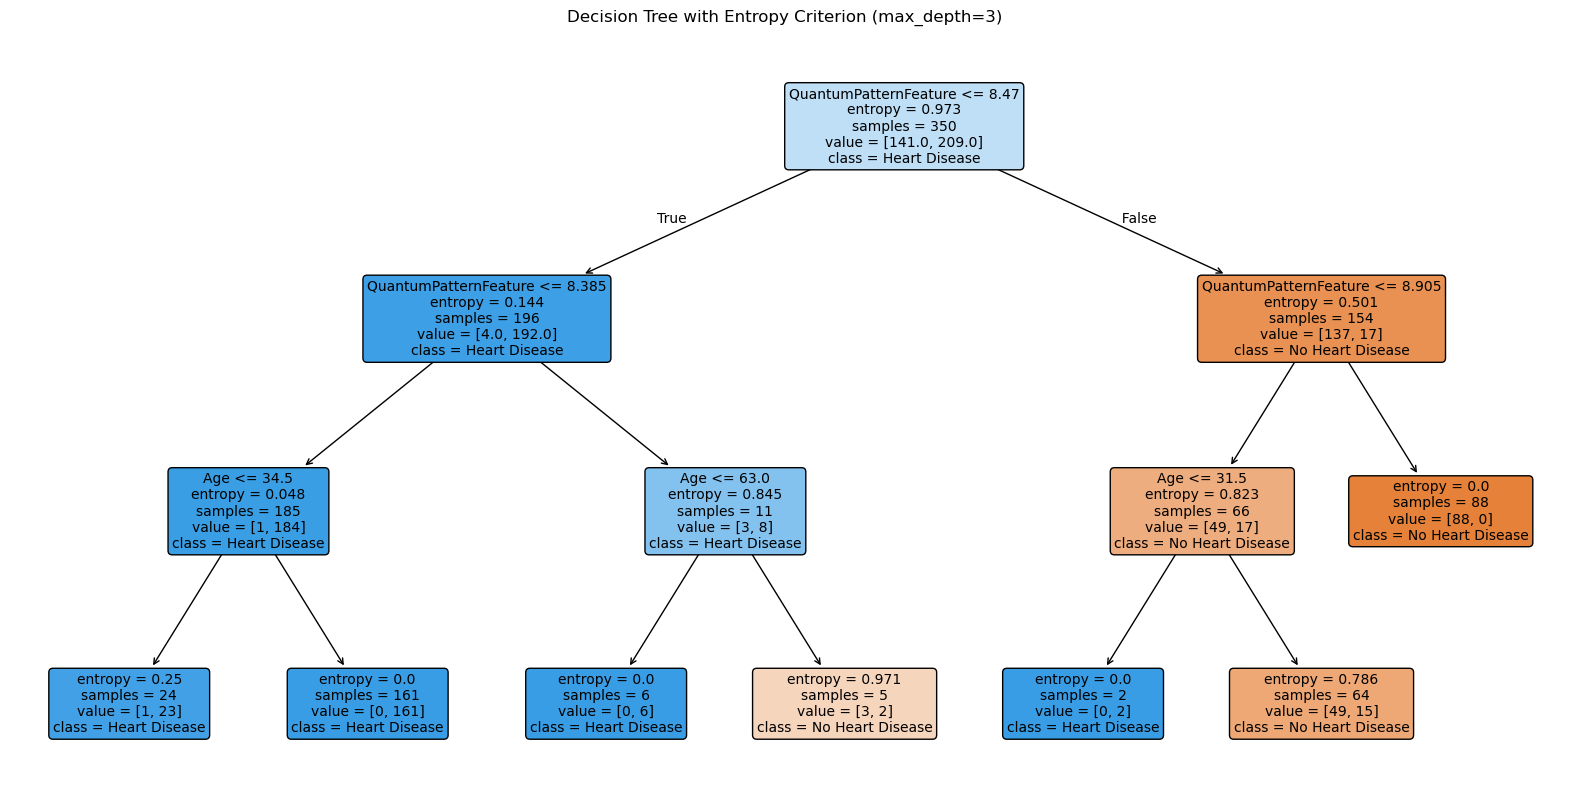

In [33]:
# Create a decision tree with Entropy criterion
tree_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)
tree_entropy.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(tree_entropy, feature_names=X.columns, class_names=['No Heart Disease', 'Heart Disease'], 
          filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree with Entropy Criterion (max_depth=3)')
plt.show()

In [34]:
# Evaluate the performance of the Entropy model
y_pred_entropy = tree_entropy.predict(X_test)
accuracy_entropy = accuracy_score(y_test, y_pred_entropy)

print(f"Accuracy of the model with Entropy criterion: {accuracy_entropy:.4f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred_entropy))

Accuracy of the model with Entropy criterion: 0.9067

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89        59
           1       0.96      0.88      0.92        91

    accuracy                           0.91       150
   macro avg       0.90      0.91      0.90       150
weighted avg       0.91      0.91      0.91       150



### 2.4 Partitions with log loss Criterion 

In [35]:
tree_log_loss = CatBoostClassifier(
    iterations=100,               # Number of trees
    depth=3,                      # Max depth of tree (equivalent to max_depth)
    loss_function='Logloss',      # Log Loss criterion
    verbose=False,                # No training output
    random_seed=42                # Random seed
)

# Train the model
tree_log_loss.fit(X_train, y_train)


In [36]:
# Get probability predictions for log loss calculation
y_prob_log_loss = tree_log_loss.predict_proba(X_test)
loss = log_loss(y_test, y_prob_log_loss)

# Also evaluate accuracy for comparison with other models
y_pred_log_loss = tree_log_loss.predict(X_test)
accuracy_log_loss = accuracy_score(y_test, y_pred_log_loss)

print(f"Log Loss of the model: {loss:.4f}")
print(f"Accuracy of the model: {accuracy_log_loss:.4f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred_log_loss))


Log Loss of the model: 0.2206
Accuracy of the model: 0.9000

Classification report:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88        59
           1       0.95      0.88      0.91        91

    accuracy                           0.90       150
   macro avg       0.89      0.91      0.90       150
weighted avg       0.91      0.90      0.90       150



### 2.5 Comparison

Model Comparison:
  Criterion  Accuracy
0      Gini  0.906667
1   Entropy  0.906667
2  Log Loss  0.900000


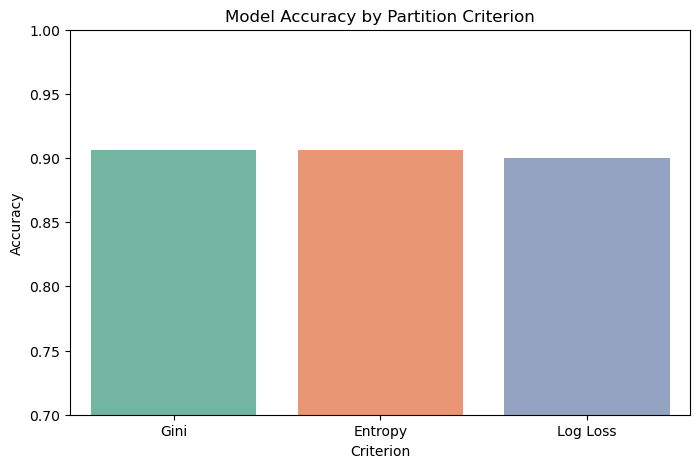

In [37]:
# Create a DataFrame to compare models
comparison_df = pd.DataFrame({
    'Criterion': ['Gini', 'Entropy', 'Log Loss'],
    'Accuracy': [accuracy_gini, accuracy_entropy, accuracy_log_loss]
})

print("Model Comparison:")
print(comparison_df)

# Plot Accuracy Comparison
plt.figure(figsize=(8, 5))
sns.barplot(data=comparison_df, x='Criterion', y='Accuracy', palette='Set2')
plt.title('Model Accuracy by Partition Criterion')
plt.ylim(0.7, 1.0)
plt.ylabel('Accuracy')
plt.show()



## 3. Conclusion

In this notebook, we compared three decision tree models using different splitting criteria: **Gini**, **Entropy**, and **Log Loss**. The goal was to understand how each criterion influences partitioning and model performance when classifying heart disease.

- Both the **Gini** and **Entropy** trees achieved the highest accuracy (90.67%) and delivered nearly identical classification results, showing they behave similarly in practice.
- The **CatBoost model with Log Loss** achieved slightly lower accuracy (90.00%) but offered well-calibrated probability outputs and a low log loss (0.2206), making it suitable for probabilistic decision-making.

**Conclusion**: For simple, interpretable trees, Gini or Entropy are strong choices with comparable performance. If calibrated probabilities are important, Log Loss with models like CatBoost is a better fit. All models showed strong performance for this dataset.
